In [1]:
%%bash

mamba install -c conda-forge torchgeo

Transaction

  Prefix: /home/taylor/miniforge3/envs/kom

  Updating specs:

   - torchgeo
   - ca-certificates
   - certifi
   - openssl


  Package                           Version  Build               Channel           Size
─────────────────────────────────────────────────────────────────────────────────────────
  Install:
─────────────────────────────────────────────────────────────────────────────────────────

  + lightly-utils                     0.0.2  pyhd8ed1ab_0        conda-forge       12kB
  + importlib-resources               6.1.0  pyhd8ed1ab_0        conda-forge       10kB
  + einops                            0.7.0  pyhd8ed1ab_1        conda-forge       40kB
  + kornia                            0.7.0  pyhd8ed1ab_0        conda-forge      413kB
  + backoff                           2.2.1  pyhd8ed1ab_0        conda-forge       18kB
  + croniter                          1.4.1  pyhd8ed1ab_0        conda-forge       37kB
  + ordered-set                       4.1.0  pyhd8ed1

In [1]:
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
import rasterio
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchgeo.samplers import RandomBatchGeoSampler

In [2]:
ROOT_DIR = Path("/mnt/data/Taylor/ml/kelp_presence_data/Nov2023ACO/raw_data")
img_path = ROOT_DIR / "ACO_CC_Goose_2020/image.tif"
label_path = ROOT_DIR / "ACO_CC_Goose_2020/label.tif"

In [3]:
with rasterio.open(img_path) as f:
    profile = f.profile
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 70566, 'height': 127672, 'count': 4, 'crs': CRS.from_epsg(3156), 'transform': Affine(0.10603100000000062, 0.0, 534185.7444425859,
       0.0, -0.10603100000000049, 5762668.201905361), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

In [4]:
class ACOImageDataset(RasterDataset):
    filename_glob = "**/image.tif"
    is_image = True
    separate_files = False
    all_bands = [1,2,3,4]
    rgb_bands = [1,2,3]

    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][rgb_indices].permute(1, 2, 0)
        image = torch.clamp(image / 255., min=0, max=1).numpy()

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

aco_imgs = ACOImageDataset(str(ROOT_DIR))
print(aco_imgs)

ACOImageDataset Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=530364.6681821644, maxx=720758.748273188, miny=5582295.63127922, maxy=5783372.601307796, mint=0.0, maxt=9.223372036854776e+18)
    size: 12


In [5]:
class ACOLabelDataset(RasterDataset):
    filename_glob = "**/label.tif"
    is_image = False
    separate_files = False
    all_bands = [1]

    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][rgb_indices].permute(1, 2, 0)
        image = torch.clamp(image / 255., min=0, max=1).numpy()

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

aco_labels = ACOImageDataset(str(ROOT_DIR))
print(aco_labels)

ACOImageDataset Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=530364.6681821644, maxx=720758.748273188, miny=5582295.63127922, maxy=5783372.601307796, mint=0.0, maxt=9.223372036854776e+18)
    size: 12


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

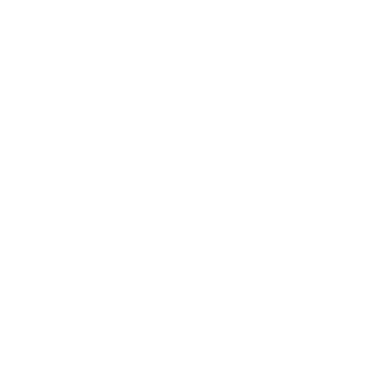

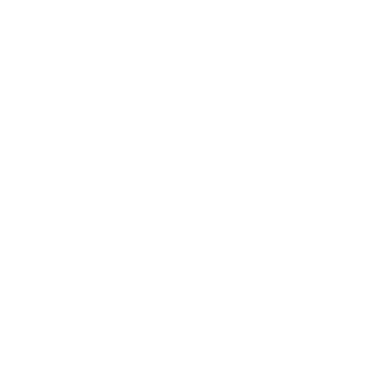

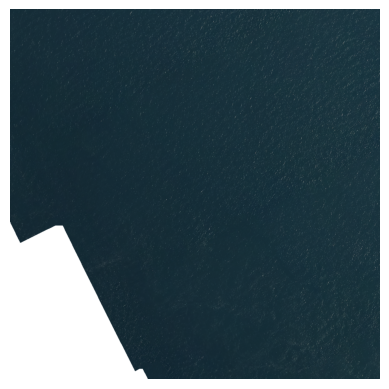

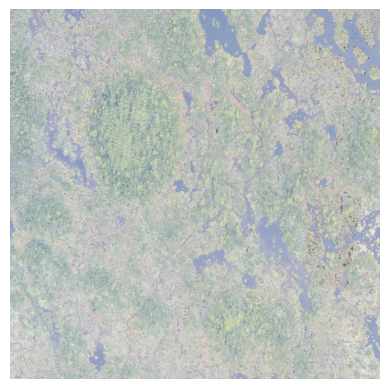

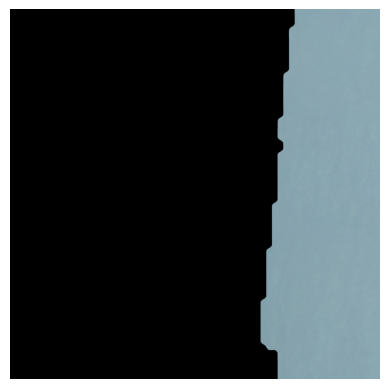

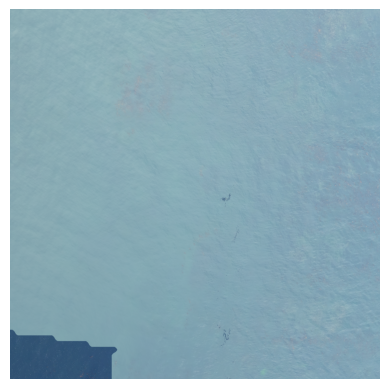

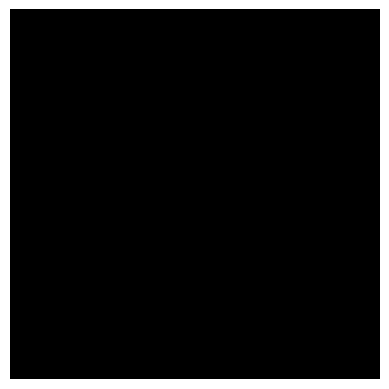

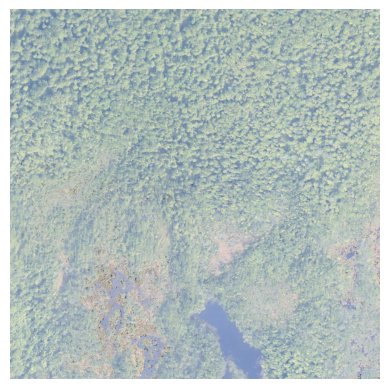

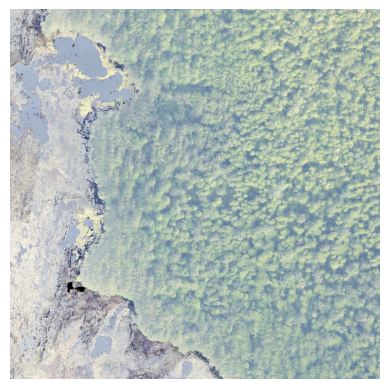

In [6]:
# torch.manual_seed(1)

BATCH_SIZE = 3
TILE_SIZE = 4096
EPOCHS = 10

dataset = aco_imgs
sampler = RandomBatchGeoSampler(dataset, size=TILE_SIZE, batch_size=BATCH_SIZE, length=EPOCHS)
dataloader = DataLoader(dataset, batch_sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    for sample in unbind_samples(batch):
        dataset.plot(sample)
        plt.axis("off")
        plt.show()

In [7]:
len(sampler)

3

In [8]:
class AccedingSequenceLengthSampler(Sampler[int]):
    def __init__(self, data: List[str]) -> None:
        self.data = data
    def __len__(self) -> int:
        return len(self.data)
    def __iter__(self) -> Iterator[int]:
        sizes = torch.tensor([len(x) for x in self.data])
        yield from torch.argsort(sizes).tolist()
        
class AccedingSequenceLengthBatchSampler(Sampler[List[int]]):
    def __init__(self, data: List[str], batch_size: int) -> None:
        self.data = data
        self.batch_size = batch_size
    def __len__(self) -> int:
        return (len(self.data) + self.batch_size - 1) // self.batch_size
    def __iter__(self) -> Iterator[List[int]]:
        sizes = torch.tensor([len(x) for x in self.data])
        for batch in torch.chunk(torch.argsort(sizes), len(self)):
            yield batch.tolist()

NameError: name 'Sampler' is not defined

In [1]:
from torch.utils.data import Sampler
import random
from shapely.affinity import affine_transform
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import triangulate
from typing import Union, List, Iterator
from torchgeo.samplers import GeoSampler
from torchgeo.samplers.constants import Units

class RandomMultiPolygonGeoSampler(Sampler[BoundingBox]):
    def __init__(
        self, 
        dataset: GeoDataset, 
        size: Union[tuple[float, float], float], 
        length: int, 
        roi=Union[Polygon, List[Polygon], MultiPolygon],
        units=Units.PIXELS,
    ) -> None:
         """Initialize a new Sampler instance.

        The ``size`` argument can either be:

        * a single ``float`` - in which case the same value is used for the height and
          width dimension
        * a ``tuple`` of two floats - in which case, the first *float* is used for the
          height dimension, and the second *float* for the width dimension

        .. versionchanged:: 0.3
           Added ``units`` parameter, changed default to pixel units

        .. versionchanged:: 0.4
           ``length`` parameter is now optional, a reasonable default will be used

        Args:
            dataset: dataset to index from
            size: dimensions of each :term:`patch`
            length: number of random samples to draw per epoch
            roi: region of interest to sample from
            units: defines if ``size`` is in pixel or CRS units
        """
        self.dataset = dataset
        self.size = size
        self.length = length
        
        self._areas = []
        self._transforms = []

        # TODO: Handle other roi datatypes
        if isinstance(roi, list):
            polygons = roi
        elif isinstance(roi, Polygon):
            polygons = [roi]
        elif isinstance(roi, MultiPolygon):
            polygons = list(roi.geoms)
        else:
            raise ValueError("Type of ROI must be Polygon, List[Polygon], or MultiPolygon")
            
        for polygon in polygons:
            assert isinstance(polygon, Polygon), "Non-polygon types can not be used as an ROI"
            
            for t in triangulate(polygon):
                self._areas.append(t.area)
                (x0, y0), (x1, y1), (x2, y2), _ = t.exterior.coords
                self._transforms.append([x1 - x0, x2 - x0, y2 - y0, y1 - y0, x0, y0])
    
    def __len__(self):
        return self.length
    
    def __iter__(self) -> Iterator[BoundingBox]:
        """Return the index of a dataset.

        Returns:
            (minx, maxx, miny, maxy, mint, maxt) coordinates to index a dataset
        """
        for transform in random.choices(self._transforms, weights=self._areas, k=self.length):
            x, y = [random.random() for _ in range(2)]
            if x + y > 1:
                p = Point(1 - x, 1 - y)
            else:
                p = Point(x, y)
            point = affine_transform(p, transform)
            
            # TODO: Get tile with point contained
            # Get a bounding box where point is the center
            
            tile = point
            return tile

NameError: name 'TILE_SIZE' is not defined